# Predição de Dengue - Modelos de Classificaao KNN, SVM e Regressão Logística


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import  pyplot as plt

from warnings import filterwarnings
filterwarnings('ignore')
import time as time
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler


### Ler Arquivos CSV

In [2]:
file='./Dados/Fortaleza/Fortaleza_Inmet_Diario.csv'
#file='../../CSV/INMET/Fortaleza/Fortaleza_InMet_82397.csv'
data = pd.read_csv(file,sep=',')
data = data.rename(columns={'Evaporacao Piche': 'Evaporacao', 'Temp Comp Media': 'TempMedia','Umidade Relativa Media':'Umidade','Velocidade do Vento Media':'VelVento'})
data



,Estacao,Data,Hora,Precipitacao,TempMaxima,TempMinima,Insolacao,Evaporacao,TempMedia,Umidade,VelVento,Semana,Ano
0,82397,01/01/2007,0,NaN,30.6,NaN,8.3,7.3,28.00,74.00,3.971840,1,2007
1,82397,01/01/2007,1200,0.0,NaN,27.4,NaN,NaN,NaN,NaN,NaN,1,2007
2,82397,02/01/2007,0,NaN,32.0,NaN,11.3,6.9,28.82,69.50,3.966667,1,2007
3,82397,02/01/2007,1200,0.0,NaN,27.1,NaN,NaN,NaN,NaN,NaN,1,2007
4,82397,03/01/2007,0,NaN,29.5,NaN,1.3,8.2,27.24,81.75,2.433333,1,2007
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9667,82397,06/06/2020,1200,0.0,NaN,24.3,NaN,NaN,NaN,NaN,NaN,23,2020
9668,82397,08/06/2020,0,NaN,31.7,NaN,9.1,NaN,NaN,82.00,NaN,24,2020
9669,82397,08/06/2020,1200,4.2,NaN,23.3,NaN,NaN,NaN,NaN,NaN,24,2020
9670,82397,09/06/2020,0,NaN,30.5,NaN,6.4,NaN,NaN,90.00,NaN,24,2020


### Incluindo colunas Ano e Semana para Agrupamento

In [3]:
#
#data['Data']=pd.to_datetime(data['Data'])
#data['Data']=pd.to_datetime(data['Data'].astype(str), format='%d/%m/%Y')
#data['Ano']=data['Data'].dt.year
#data['Semana']=data['Data'].dt.week
#data

In [4]:
#file2='../../CSV/GISSA_INFECTADOS/infectados_diario_Fortaleza.csv'
file2='./Dados/Fortaleza/Fortaleza_Infectados_Diarios.csv'
data2 = pd.read_csv(file2,sep=',')
data2 = data2.rename(columns={'Data_Notificacao':'Data','Infectados_Dengue':'Infectados'})
data2


,Data,Infectados,Semana,Ano
0,01/01/2007,6,1,2007
1,02/01/2007,10,1,2007
2,03/01/2007,26,1,2007
3,04/01/2007,20,1,2007
4,05/01/2007,22,1,2007
...,...,...,...,...
4921,22/06/2020,4,26,2020
4922,23/06/2020,4,26,2020
4923,24/06/2020,0,26,2020
4924,25/06/2020,0,26,2020


In [5]:
# Incluindo Ano e Semana
#data2['Data']=pd.to_datetime(data2['Data'].astype(str), format='%d/%m/%Y')
#data2['Ano']=data2['Data'].dt.year
#data2['Semana']=data2['Data'].dt.week
#data2

### Verificar dados faltando no dataset Inmet

In [6]:
tot_nulos=data.isnull().sum()
tot_nulos

Estacao            0
Data               0
Hora               0
Precipitacao    4827
TempMaxima      4850
TempMinima      4847
Insolacao       5022
Evaporacao      5495
TempMedia       5045
Umidade         5054
VelVento        4868
Semana             0
Ano                0
dtype: int64

In [7]:
data.head()

,Estacao,Data,Hora,Precipitacao,TempMaxima,TempMinima,Insolacao,Evaporacao,TempMedia,Umidade,VelVento,Semana,Ano
0,82397,01/01/2007,0,NaN,30.6,NaN,8.3,7.3,28.00,74.00,3.971840,1,2007
1,82397,01/01/2007,1200,0.0,NaN,27.4,NaN,NaN,NaN,NaN,NaN,1,2007
2,82397,02/01/2007,0,NaN,32.0,NaN,11.3,6.9,28.82,69.50,3.966667,1,2007
3,82397,02/01/2007,1200,0.0,NaN,27.1,NaN,NaN,NaN,NaN,NaN,1,2007
4,82397,03/01/2007,0,NaN,29.5,NaN,1.3,8.2,27.24,81.75,2.433333,1,2007


### Os dados diários estão duplicados, pois existem duas medições diáris. Vamos excluir uma das medições

In [8]:
data["Precipitacao"].fillna( method ='backfill', limit = 1, inplace = True) 
data["TempMinima"].fillna( method ='backfill', limit = 1, inplace = True) 
data["TempMaxima"].fillna( method ='backfill', limit = 1, inplace = True) 
data["Insolacao"].fillna( method ='backfill', limit = 1, inplace = True) 
data["Evaporacao"].fillna( method ='backfill', limit = 1, inplace = True) 
data["TempMedia"].fillna( method ='backfill', limit = 1, inplace = True) 
data["Umidade"].fillna( method ='backfill', limit = 1, inplace = True) 
data["VelVento"].fillna( method ='backfill', limit = 1, inplace = True) 

Indices=[x for x in data.index if x%2==1]
data.drop(Indices, inplace=True)
data.reset_index(inplace = True, drop = True)

data

,Estacao,Data,Hora,Precipitacao,TempMaxima,TempMinima,Insolacao,Evaporacao,TempMedia,Umidade,VelVento,Semana,Ano
0,82397,01/01/2007,0,0.0,30.6,27.4,8.3,7.3,28.00,74.00,3.971840,1,2007
1,82397,02/01/2007,0,0.0,32.0,27.1,11.3,6.9,28.82,69.50,3.966667,1,2007
2,82397,03/01/2007,0,0.5,29.5,25.9,1.3,8.2,27.24,81.75,2.433333,1,2007
3,82397,04/01/2007,0,7.9,31.3,25.9,11.2,3.1,27.80,71.50,3.166667,1,2007
4,82397,05/01/2007,0,2.7,28.7,24.0,3.0,5.9,26.52,83.75,3.766667,1,2007
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4831,82397,04/06/2020,0,0.8,31.7,24.7,3.8,NaN,NaN,88.00,NaN,23,2020
4832,82397,05/06/2020,0,5.4,31.6,23.9,7.3,NaN,NaN,82.00,NaN,23,2020
4833,82397,06/06/2020,0,0.0,30.8,24.3,8.4,NaN,NaN,84.00,NaN,23,2020
4834,82397,08/06/2020,0,4.2,31.7,23.3,9.1,NaN,NaN,82.00,NaN,24,2020


### Verifica novamente se existem nulos

In [9]:
tot_nulos=data.isnull().sum()
tot_nulos

Estacao           0
Data              0
Hora              0
Precipitacao      1
TempMaxima       14
TempMinima       11
Insolacao       186
Evaporacao      659
TempMedia       209
Umidade         218
VelVento         32
Semana            0
Ano               0
dtype: int64

### Estes são nulos de verdade. Vamos substituir pela média

In [10]:
data['Precipitacao'].fillna(data['Precipitacao'].mean(),inplace=True)
data['TempMaxima'].fillna(data['TempMaxima'].mean(),inplace=True)
data['TempMinima'].fillna(data['TempMinima'].mean(),inplace=True)
data['Insolacao'].fillna(data['Insolacao'].mean(),inplace=True)
data['Evaporacao'].fillna(data['Evaporacao'].mean(),inplace=True)
data['TempMedia'].fillna(data['TempMedia'].mean(),inplace=True)
data['Umidade'].fillna(data['Umidade'].mean(),inplace=True)
data['VelVento'].fillna(data['VelVento'].mean(),inplace=True)
tot_nulos=data.isnull().sum()
tot_nulos

Estacao         0
Data            0
Hora            0
Precipitacao    0
TempMaxima      0
TempMinima      0
Insolacao       0
Evaporacao      0
TempMedia       0
Umidade         0
VelVento        0
Semana          0
Ano             0
dtype: int64

### Agrupando dados Metereológicos para Semanais

In [11]:
dataSemana = data.groupby(by=['Ano','Semana'], as_index=False)['Precipitacao','TempMaxima','TempMinima','Insolacao','Evaporacao','TempMedia',	'Umidade',	'VelVento'].sum()
#dataSemana = data


In [12]:
dataSemana

,Ano,Semana,Precipitacao,TempMaxima,TempMinima,Insolacao,Evaporacao,TempMedia,Umidade,VelVento
0,2007,1,17.9,183.6,155.2,45.5,35.000000,166.320000,454.25,21.605174
1,2007,2,18.2,220.9,177.7,58.6,40.100000,195.440000,541.25,23.466666
2,2007,3,1.2,226.1,184.9,59.3,39.200000,199.820000,520.75,24.966668
3,2007,4,0.0,225.2,183.9,62.2,45.600000,199.860000,511.50,23.214440
4,2007,5,9.7,223.8,184.6,43.4,38.600000,198.180000,543.25,20.033333
...,...,...,...,...,...,...,...,...,...,...
704,2020,20,63.4,182.0,146.3,29.3,25.455830,164.632367,517.00,13.847808
705,2020,21,127.7,188.0,146.2,34.4,25.455830,163.057100,513.00,16.850305
706,2020,22,33.4,191.1,144.3,50.9,25.455830,163.057100,501.00,16.850305
707,2020,23,14.2,189.1,145.0,41.8,25.455830,163.057100,509.00,16.850305


### Examina o gráfico dos atributos

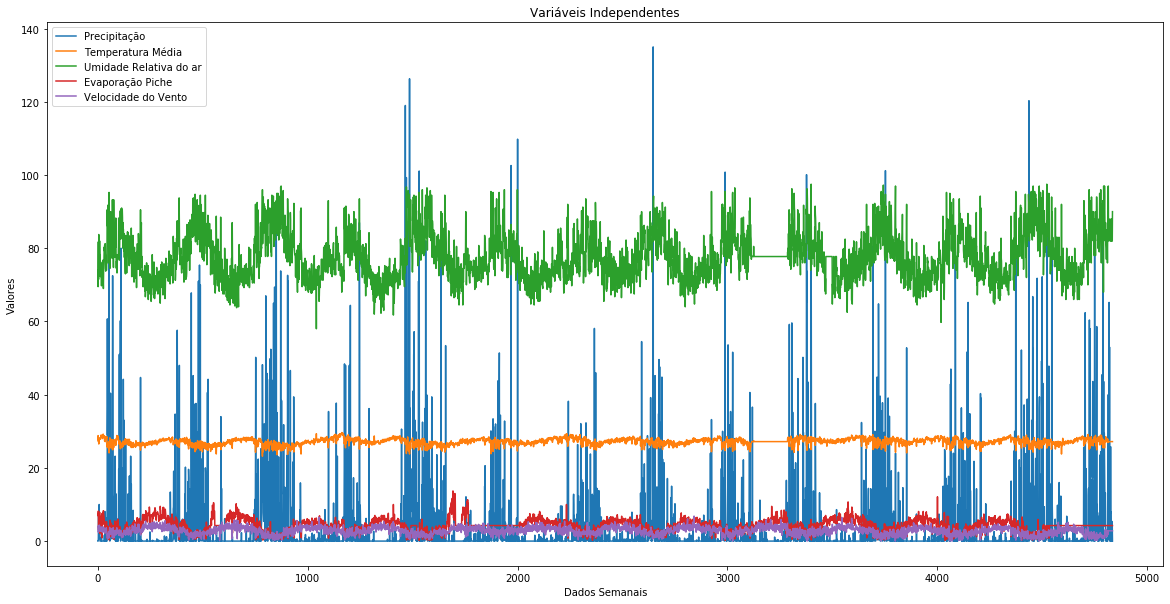

In [13]:

plt.figure(figsize=(20,10))
data.Precipitacao.plot(label="Precipitação")
data.TempMedia.plot( label="Temperatura Média")
data.Umidade.plot( label="Umidade Relativa do ar")
data.Evaporacao.plot( label="Evaporação Piche")
data.VelVento.plot( label="Velocidade do Vento")
plt.title("Variáveis Independentes")
plt.legend()
plt.xlabel('Dados Semanais')
plt.ylabel('Valores')

plt.show()

### Verifica Nulos da variável dependente - N. de infectados.

In [14]:
tot_nulos=data2.isnull().sum()
tot_nulos

Data          0
Infectados    0
Semana        0
Ano           0
dtype: int64

In [15]:
data2

,Data,Infectados,Semana,Ano
0,01/01/2007,6,1,2007
1,02/01/2007,10,1,2007
2,03/01/2007,26,1,2007
3,04/01/2007,20,1,2007
4,05/01/2007,22,1,2007
...,...,...,...,...
4921,22/06/2020,4,26,2020
4922,23/06/2020,4,26,2020
4923,24/06/2020,0,26,2020
4924,25/06/2020,0,26,2020


### Agrupar  por semana e plota o gráfico da variável dependente

In [16]:
data2Semana = data2.groupby(by=['Ano','Semana'], as_index=False).sum()
for col_name in data2Semana:
    print(col_name)
#data2Semana=data2

Ano
Semana
Infectados


In [17]:
data2Semana.describe()

,Ano,Semana,Infectados
count,715.000000,715.000000,715.000000
mean,2013.254545,26.509091,382.864336
std,3.902465,15.305237,773.811880
min,2007.000000,1.000000,1.000000
25%,2010.000000,13.000000,50.500000
50%,2013.000000,26.000000,126.000000
75%,2017.000000,40.000000,348.000000
max,2020.000000,53.000000,6233.000000


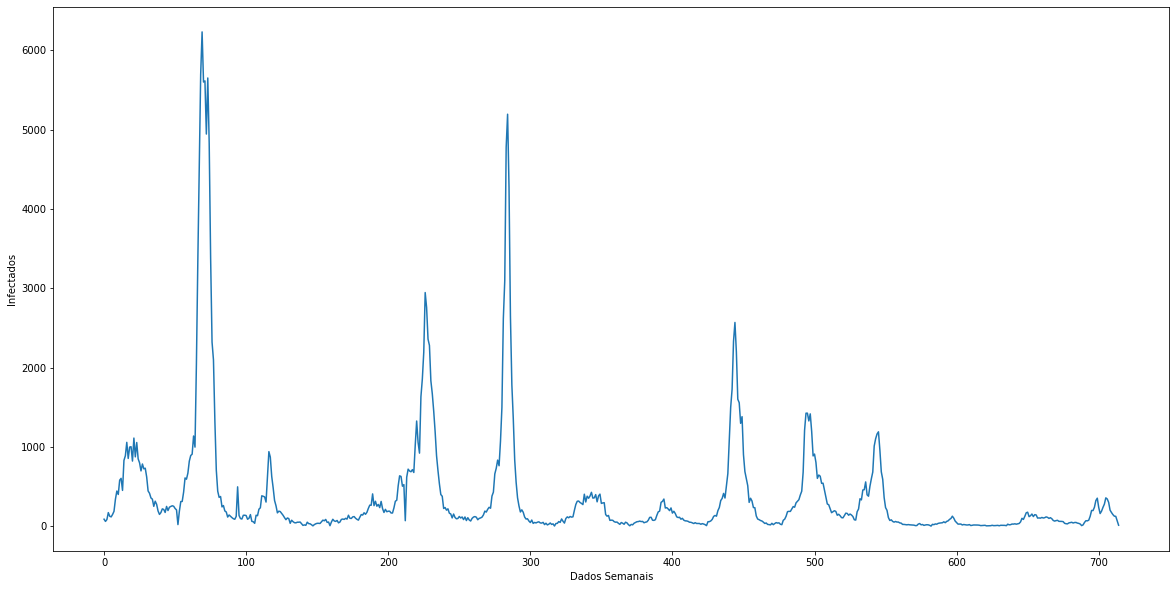

In [18]:
# Analisar dados de "Infectados" ao longo do tempo
plt.figure(figsize=(20,10))
plt.xlabel('Dados Semanais')
plt.ylabel('Infectados')
plt.plot(data2Semana['Infectados'])
plt.show()

### Verifica-se um outlier  em 2007 - Vamos excluir

In [19]:
#data2Semana=data2Semana.iloc[53:,:]
#data2Semana

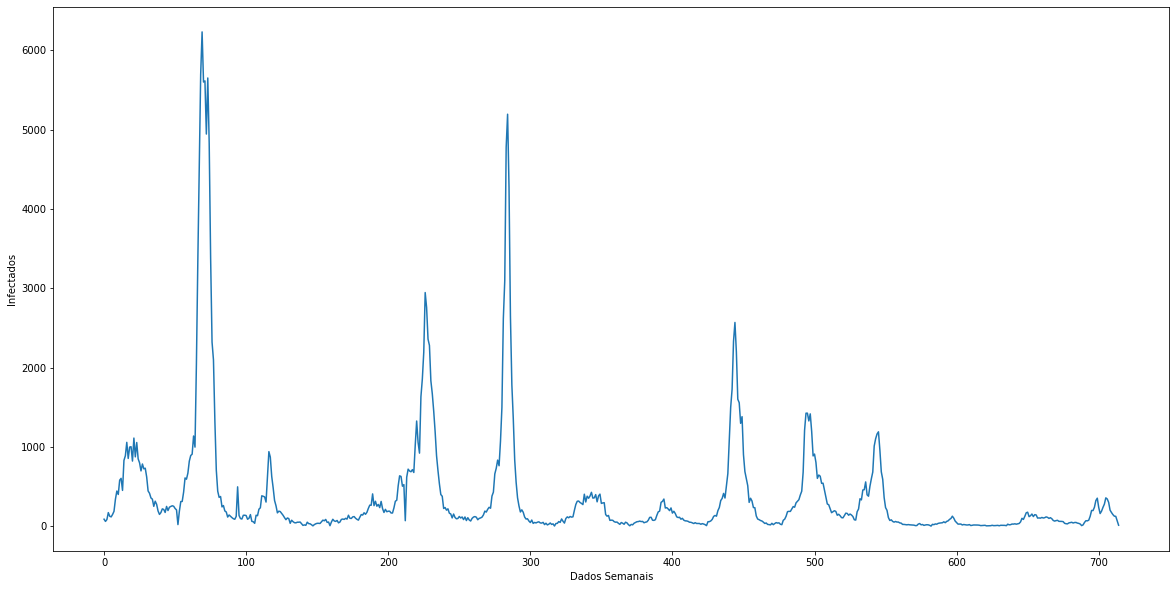

In [20]:
# Analisar dados de "Infectados" ao longo do tempo
plt.figure(figsize=(20,10))
plt.xlabel('Dados Semanais')
plt.ylabel('Infectados')
plt.plot(data2Semana['Infectados'])
plt.show()

### Excluir também  ano de 2007 dos atributos

In [21]:
#dataSemana=dataSemana.iloc[53:,:]
#dataSemana

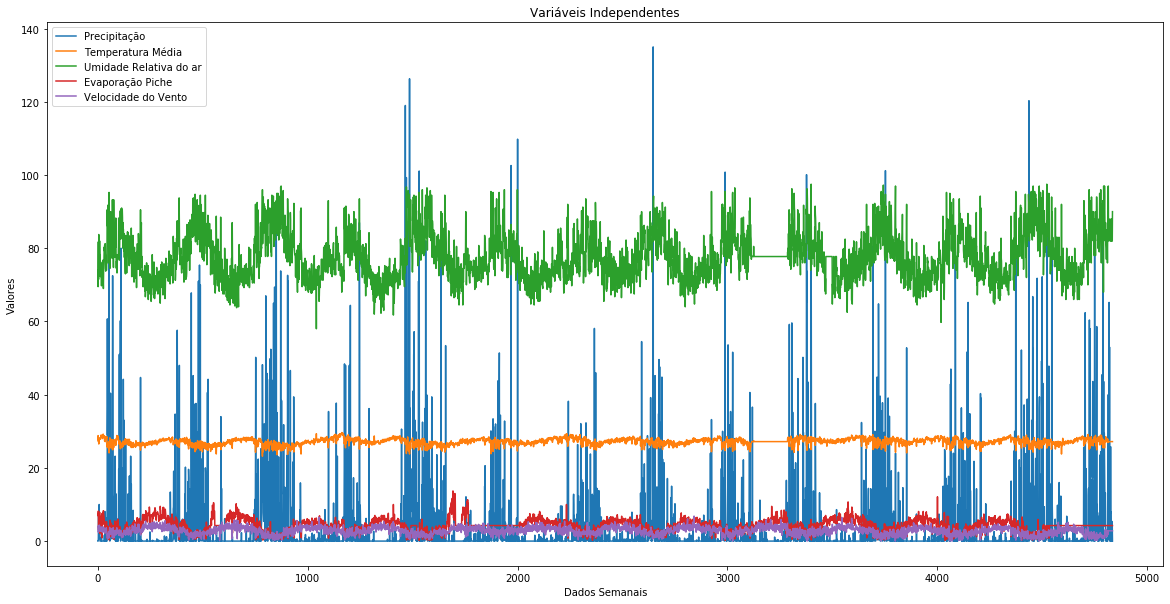

In [22]:
plt.figure(figsize=(20,10))
data.Precipitacao.plot(label="Precipitação")
data.TempMedia.plot( label="Temperatura Média")
data.Umidade.plot( label="Umidade Relativa do ar")
data.Evaporacao.plot( label="Evaporação Piche")
data.VelVento.plot( label="Velocidade do Vento")
plt.title("Variáveis Independentes")
plt.legend()
plt.xlabel('Dados Semanais')
plt.ylabel('Valores')

plt.show()

### Separando dados para treino e teste

In [23]:
X_train = dataSemana[(dataSemana['Ano']>=2007) & (dataSemana['Ano']<=2015)] 
X_test = dataSemana[(dataSemana['Ano']>=2016)] 
y_train = data2Semana[(data2Semana['Ano']>=2007) & (data2Semana['Ano']<=2015)]
submission = data2Semana[(data2Semana['Ano']>=2016)] 

submission

,Ano,Semana,Infectados
477,2016,1,19
478,2016,2,74
479,2016,3,88
480,2016,4,125
481,2016,5,183
...,...,...,...
710,2020,22,146
711,2020,23,126
712,2020,24,124
713,2020,25,68


### Normalizador estatístico, onde o resultado da normalização garante média zero e variância/desvio parão unitária.

In [24]:
normalizador = StandardScaler()

X_train.iloc[:,2:] = normalizador.fit_transform(X_train.iloc[:,2:])
X_test.iloc[:,2:] = normalizador.transform(X_test.iloc[:,2:])
X_train,X_test,y_train

(      Ano  Semana  Precipitacao  TempMaxima  TempMinima  Insolacao  \
 0    2007       1     -0.226426   -1.541162   -0.555681  -0.571676   
 1    2007       2     -0.219489    0.242657    0.825833   0.299491   
 2    2007       3     -0.612546    0.491339    1.267917   0.346042   
 3    2007       4     -0.640291    0.448298    1.206517   0.538895   
 4    2007       5     -0.416018    0.381345    1.249497  -0.711329   
 ..    ...     ...           ...         ...         ...        ...   
 472  2015      49     -0.635667    0.639592    0.660051  -0.006728   
 473  2015      50     -0.570928    0.625245    0.574091  -0.006728   
 474  2015      51     -0.492317    0.500904    0.684612  -0.006728   
 475  2015      52     -0.006776    0.419604    0.457429  -0.006728   
 476  2015      53     -0.395209   -2.636321   -2.483660  -1.032659   
 
      Evaporacao  TempMedia   Umidade  VelVento  
 0      0.470848  -1.139239 -1.270987  0.232385  
 1      0.916939   0.483536  0.137017  0.55065

Nossa variável de destino, "Infectados" é um número inteiro não negativo, o que significa que estamos procurando fazer algumas previsões de contagem. As técnicas de regressão padrão para esse tipo de previsão incluem:
Regressão de Poisson
Regressão binomial negativa.

Qual técnica terá melhor desempenho depende de muitas coisas, mas a escolha entre a regressão de Poisson e a regressão binomial negativa é bastante direta.

A regressão de Poisson se ajusta de acordo com a suposição de que a média e a variância da distribuição da população são iguais. Quando não são, especificamente quando a variação é muito maior que a média, a abordagem binomial negativa é melhor.

A regressão binomial negativa simplesmente levanta a suposição de que a média e variância da população são iguais, permitindo uma classe maior de modelos possíveis. De fato, dessa perspectiva, a distribuição de Poisson é apenas um caso especial da distribuição binomial negativa.

In [25]:
y_train.describe()

,Ano,Semana,Infectados
count,477.0000,477.000000,477.000000
mean,2011.0000,27.000000,479.025157
std,2.5847,15.313118,910.743297
min,2007.0000,1.000000,2.000000
25%,2009.0000,14.000000,71.000000
50%,2011.0000,27.000000,169.000000
75%,2013.0000,40.000000,404.000000
max,2015.0000,53.000000,6233.000000


In [26]:
print('Media e Variancia dos Infectados')
print('mean: ', y_train.mean()[2])
print('std :', y_train.std()[2])
print('var :', y_train.var()[2])

Media e Variancia dos Infectados
mean:  479.02515723270443
std : 910.7432966028138
var : 829453.3523069608


Variancia maior que media sugere que a variável "Infectados" pode ser descrita por uma distribuição binomial negativa; portanto, usaremos uma regressão binomial negativa abaixo. 

Vamos analisar as Correlações


In [27]:
X_corr = X_train[['Precipitacao','Insolacao','Evaporacao','TempMinima','TempMaxima','TempMedia','Umidade','VelVento']]
X_corr


,Precipitacao,Insolacao,Evaporacao,TempMinima,TempMaxima,TempMedia,Umidade,VelVento
0,-0.226426,-0.571676,0.470848,-0.555681,-1.541162,-1.139239,-1.270987,0.232385
1,-0.219489,0.299491,0.916939,0.825833,0.242657,0.483536,0.137017,0.550656
2,-0.612546,0.346042,0.838217,1.267917,0.491339,0.727621,-0.194754,0.807120
3,-0.640291,0.538895,1.398017,1.206517,0.448298,0.729850,-0.344456,0.507531
4,-0.416018,-0.711329,0.785735,1.249497,0.381345,0.636229,0.169385,-0.036361
...,...,...,...,...,...,...,...,...
472,-0.635667,-0.006728,1.441752,0.660051,0.639592,0.193381,0.183833,0.821368
473,-0.570928,-0.006728,0.908192,0.574091,0.625245,0.193381,0.183833,1.009441
474,-0.492317,-0.006728,1.004408,0.684612,0.500904,0.193381,0.183833,1.231710
475,-0.006776,-0.006728,0.995661,0.457429,0.419604,0.193381,0.183833,1.017990


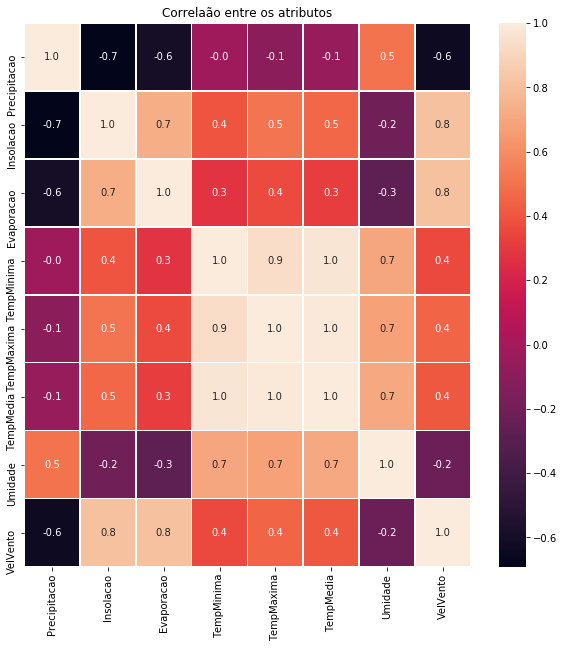

In [28]:
f,ax = plt.subplots(figsize=(10, 10))
sns.heatmap(X_corr.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)
ax.set_title('Correlaão entre os atributos')
plt.show()


### Verifica-se que TempMaxima e TemMinima estão fortemente relacionada com TempMedia, sugerindo que podemos excluir estes 2  atributos.

In [29]:
delete = ['TempMinima','TempMaxima']
for z in delete:
    del X_train[z]
    del X_test[z]
X_corr = X_train[['Precipitacao','Insolacao','Evaporacao','TempMedia','Umidade','VelVento']]

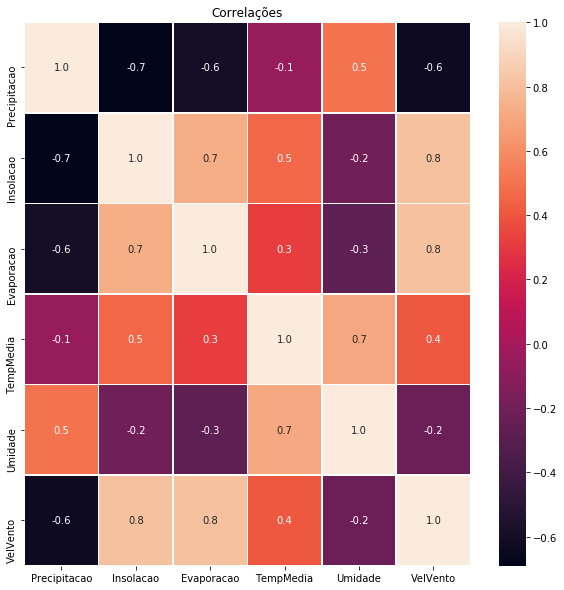

In [30]:
X_train['Infectados'] = y_train['Infectados']

f,ax = plt.subplots(figsize=(10, 10))
sns.heatmap(X_corr.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)
ax.set_title('Correlações')
plt.show()

### Vamos verificar a correlação dos atributos com a variável dependente

Text(0.5, 1.0, 'Correlações')

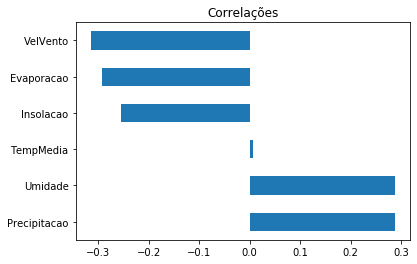

In [31]:
X_corr=X_train.iloc[:,2:]
correlations = X_corr.corr()
(correlations['Infectados'].drop('Infectados').sort_values(ascending=False).plot.barh())
plt.title('Correlações')

### Verificamos que a Precipitação e Vel. do Vento são as que têm mais forte correlação com o N. de Infectados

### Vamos plotar o número de infectados para cada ano

Text(0, 0.5, 'Total de Infectados')

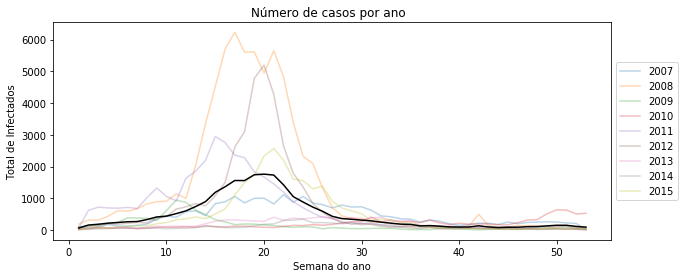

In [32]:
#Numero de Casos por semana
for i in set(y_train['Ano']):
    df = y_train[y_train['Ano'] == i]
    df.set_index('Semana', drop = True, inplace = True)
    plt.plot(df['Infectados'], alpha = .3)
    
y_train.groupby('Semana')['Infectados'].mean().plot(c = 'k', figsize = (10,4))
plt.legend(set(y_train['Ano']), loc='center left', bbox_to_anchor=(1, .5))

plt.title('Número de casos por ano  ')
plt.xlabel('Semana do ano')
plt.ylabel('Total de Infectados')

###  Verificas uma incidência maior de dengue no final do primeiro semestre, que coincide com o final do período chuvoso no Ceará

## Construindo modelos de Machine Learning
### Agora que temos uma compreensão mais clara do nosso conjunto de dados, continuaremos a construir nossos modelos de ML.


In [33]:
#features=['Infectados','Precipitacao','Insolacao','Evaporacao','TempMedia','Umidade','VelVento'] 
features=['Infectados','Precipitacao','Insolacao','Evaporacao','Umidade','VelVento'] 

X_train=X_train.join(X_train.groupby(['Semana'])['Infectados'].mean(), on=['Semana'], rsuffix='_avg')
X_test=X_test.join(X_train.groupby(['Semana'])['Infectados'].mean(), on=['Semana'], rsuffix='_avg')

#TRAIN
X= X_train[features]
Y = X_train['Infectados']

#TEST
Xt= X_test[features]
X.fillna(method='bfill', inplace=True)
Xt.fillna(method='bfill', inplace=True)


## Criando os modelos e treinando 

### SVM - (Support Vetor Machine / SRV - Support vetor Regression)

In [34]:

svr = GridSearchCV(SVR(kernel='rbf', gamma=0.1), cv=5,
                   param_grid={"C": [1e0, 1e1, 1e2, 1e3],
                               "gamma": np.logspace(-2, 2, 5)})
t0 = time.time()
svr.fit(X,Y)

svr_fit = time.time() - t0
print("Complexidade SVR e largura de banda selecionadas e modelo ajustado em %.3f s"
      % svr_fit)
model=svr.best_estimator_
print(model)


Complexidade SVR e largura de banda selecionadas e modelo ajustado em 3.216 s
SVR(C=1000.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.01,
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)


###   KNN (k-nearest neighbors )

In [35]:
knn = KNeighborsClassifier(n_neighbors = 30)
knn.fit(X,Y)


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=30, p=2,
                     weights='uniform')

### Regressão Logística

In [36]:
logreg = LogisticRegression()
logreg.fit(X, Y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

### Separa dados de treino (70%)  e teste (30%) Para VALIDAÇÃO

In [37]:
train_subtrain = X_train.sample(frac=0.7)
train_subtest = X_train.loc[~X_train.index.isin(train_subtrain.index)]

train_subtrain.fillna(method='bfill', inplace=True)
train_subtest.fillna(method='bfill', inplace=True)

#X_train.describe()
train_subtest.describe()


,Ano,Semana,Precipitacao,Insolacao,Evaporacao,TempMedia,Umidade,VelVento,Infectados,Infectados_avg
count,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000
mean,2011.160839,26.657343,0.091835,-0.008540,0.066126,0.067827,0.072907,0.014848,397.034965,453.878011
std,2.652796,14.848581,1.149188,1.013121,1.084456,0.638209,0.765296,1.056260,630.411417,480.140408
min,2007.000000,1.000000,-0.640291,-2.699717,-1.943293,-6.007565,-4.685799,-2.224853,7.000000,61.555556
25%,2009.000000,13.000000,-0.621794,-0.624877,-0.744969,-0.072064,-0.386938,-0.822851,76.000000,120.111111
50%,2011.000000,27.000000,-0.492317,0.226339,0.007129,0.127997,0.043959,0.203005,175.000000,245.333333
75%,2013.000000,39.000000,0.313449,0.788275,0.654532,0.297965,0.578029,0.938201,375.500000,552.166667
max,2015.000000,53.000000,5.260183,1.343561,3.908374,0.798952,1.447916,1.895667,4945.000000,1760.333333


### Cria Predições

In [38]:
preds= model.predict(train_subtest[features]).astype(int)
#SVM
#add to the dataframes
train_subtest['fitted'] = preds

# KNN
preds2 = knn.predict(train_subtest[features]).astype(int)
train_subtest['fitted2'] = preds2
#train_subtest.index = train_subtest['week_start_date']

# Logistic regression
preds3 = logreg.predict(train_subtest[features]).astype(int)
train_subtest['fitted3'] = preds3
#train_subtest.index = train_subtest['week_start_date']


### Plotagem das predições com parte de dados de teste (30%)

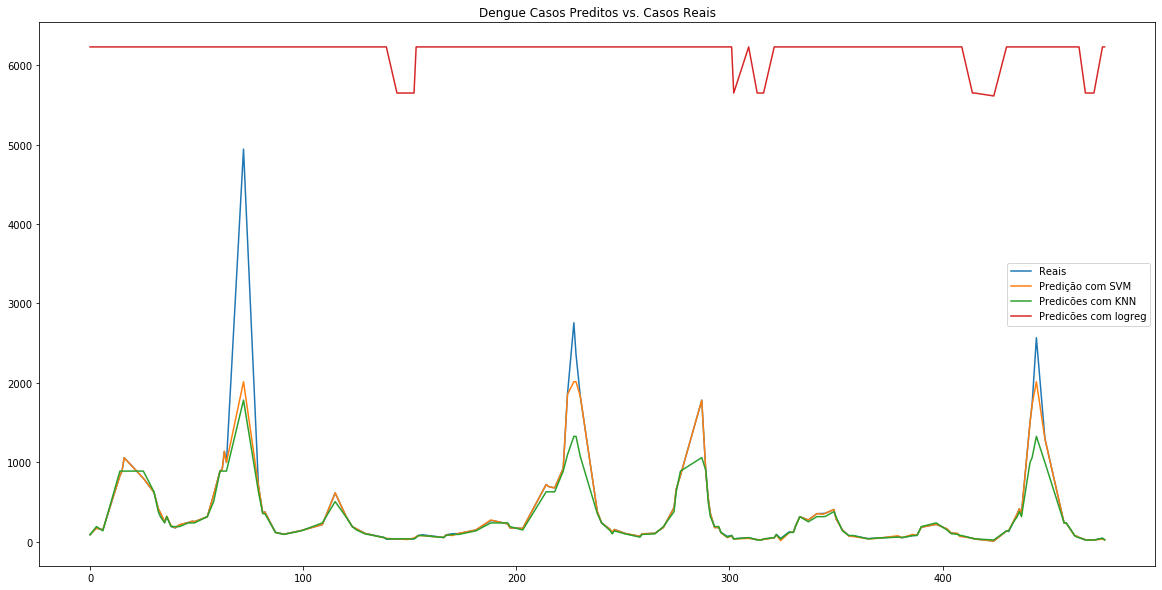

In [39]:

plt.figure(figsize=(20,10))
train_subtest.Infectados.plot(label="Reais")
train_subtest.fitted.plot( label="Predição com SVM")
train_subtest.fitted2.plot( label="Predicões com KNN")
train_subtest.fitted3.plot( label="Predicões com logreg")
plt.title("Dengue Casos Preditos vs. Casos Reais")
plt.legend()


## Calcula as métricas  - Cross validation com o score R2

### Scores para SVR

In [40]:
scores = cross_val_score(svr, X,Y, cv=5, scoring = "r2")
print("Scores usando SVR:", scores)
print("Média  usando SVR:", scores.mean())

Scores usando SVR: [0.10845266 0.75535369 0.25795681 0.76701393 0.78908439]
Média  usando SVR: 0.5355722957552136


### Scores para KNN

In [41]:
scores = cross_val_score(knn, X,Y, cv=5, scoring = "r2")
print("Scores usando KNN:", scores)
print("Média  usando KNN:", scores.mean())

Scores usando KNN: [0.47523777 0.51269021 0.50789611 0.50339472 0.47474534]
Média  usando KNN: 0.4947928311710045


### Scores para Regressão Logística

In [42]:
scores = cross_val_score(logreg, X,Y, cv=5, scoring = "r2")
print("Scores usando Reg. Logística:", scores)
print("Média usando Reg. Logística:", scores.mean())

Scores usando Reg. Logística: [-32.26213448 -49.14073671 -39.59040288 -37.63792243 -33.89337664]
Média usando Reg. Logística: -38.50491462870217


### Podemos afirmar, de acordo com os scores, que SVR e Reg. Logística fornecem bons resultados

## Fazendo predições com dados de teste para cada algoritmo

### Predição KNN

In [45]:
knn.fit(X,Y)
predictions = knn.predict(Xt).astype(int)
submission.Infectados = np.concatenate([predictions])

plt.figure(figsize=(20,10))
X_test.Infectados.plot(label="Reais")

submission.Infectados.plot( label="Predicões com KNN")

plt.title("Dengue Casos Preditos vs. Casos Reais")
plt.legend()

ValueError: Length of values does not match length of index

### Predição SVM

In [44]:
#Predição SVM

model.fit(X,Y)
predictions2 = model.predict(Xt).astype(int)

submission.Infectados = np.concatenate([predictions2])

plt.figure(figsize=(20,10))
X_test.Infectados.plot(label="Reais")
submission.Infectados.plot( label="Predição com SVM")
plt.title("Dengue Casos Preditos vs. Casos Reais")
plt.legend()

ValueError: Length of values does not match length of index

### Predição Regressão Logística

In [ ]:

logreg.fit(X,Y)
predictions3 = logreg.predict(Xt).astype(int)

submission.Infectados = np.concatenate([predictions3])


plt.figure(figsize=(20,10))
X_test.Infectados.plot(label="Reais")

submission.Infectados.plot( label="Regressão Logistica")
plt.title("Dengue Casos Preditos vs. Casos Reais")
plt.legend()

### Concluimos que os modelos baseados em SVM e Regressão logística funcionam muito bem para previsão de casos dengue